In [20]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import optimize
import matplotlib.pyplot as plt

def f_objective(theta, X, y, l2_param=0.01):
    '''
    Args:
        theta: 1D numpy array of size num_features
        X: 2D numpy array of size (num_instances, num_features)
        y: 1D numpy array of size num_instances
        l2_param: regularization parameter

    Returns:
        objective: scalar value of objective function
    '''
    n = X.shape[0]#num_instances
    objective = 0
    for i in range(n):
        objective += np.logaddexp(0, -y[i]*np.dot(theta, X[i,:])) 
    
    return (objective/n + l2_param*np.linalg.norm(theta))

def fit_logistic_reg(X, y, objective_function, l2_param=0.01):
    '''
    Args:
        X: 2D numpy array of size (num_instances, num_features)
        y: 1D numpy array of size num_instances
        objective_function: function returning the value of the objective
        l2_param: regularization parameter
        
    Returns:
        optimal_theta: 1D numpy array of size num_features
    '''
    #Initialize theta
    m = X.shape[1]#number of features
    theta_0 = np.random.standard_normal(m)

    #Optimize the objective function
    res = optimize.minimize(objective_function,x0=theta_0, args=(X, y, l2_param,))
    optimal_theta = res.x
    return optimal_theta

#Load train & val data
X_train, X_val = np.loadtxt("X_train.txt",delimiter=','), np.loadtxt("X_val.txt",delimiter=',')
y_train, y_val = np.loadtxt("y_train.txt"), np.loadtxt("y_val.txt")

#Incorporate intercept term
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
X_val = np.hstack([np.ones([X_val.shape[0],1]), X_val])

#Data standardization
scale = StandardScaler().fit(X_train)
X_train_stand = scale.transform(X_train)
X_val_stand = scale.transform(X_val)

#Fit logistic regression and get the optimized theta on training data
optimized_theta = fit_logistic_reg(X_train_stand, y_train, f_objective, l2_param=0.01)
print(optimized_theta)

[ 2.46825818e-06 -1.95105999e-02  4.60914901e-03  2.17335230e-01
  7.02823047e-01 -5.61332624e-02 -1.40997983e-02 -1.75037038e-02
 -4.97916530e-02 -6.21943372e-02 -3.38641344e-01  8.53245595e-02
  1.83568251e-02 -1.20250035e-01  5.74110308e-03 -3.28463550e-02
  4.43672348e-03  5.41696096e-03 -7.78067744e-02 -7.83356122e-02
 -1.19289562e-01]


[29139798940.88096, 10889962736.598228, 31417396007325.527, 3892032999.3455377, 90848964.8314037, 155651019.21603024, 5188916528.560447, 249.31731619374065, 248.7114812150405, 261.49890449604106, 277.2588734790257, 277.25887308026137, 277.2588732406247, 277.258832492729]


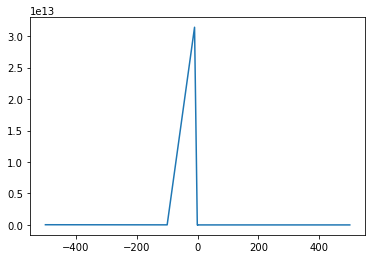

In [25]:
#Plot the log-likelihood for different values of l2-param
def log_likelihood(theta, X, y):
    """
    Args:
        theta: 1D numpy array of size num_features
        l2_param: regularization parameter
        X: 2D numpy array of size (num_instances, num_features)
        y: 1D numpy array of size num_instances
    Returns:
        l_likelihood: log-likelihood on the dataset (X,y)
    """
    l_likelihood = 0
    n = X.shape[0]#num_instances
    for i in range(n):
        l_likelihood += np.logaddexp(0, -y[i]*np.dot(theta, X[i,:])) 
    return l_likelihood

likelihoods = [ ]
for l2 in (-500,-100,-10,-1,-0.1,-0.01, -0.001,0.001, 0.01, 0.1, 1, 10, 100, 500):
    optimized_theta = fit_logistic_reg(X_val_stand, y_val, f_objective, l2_param=l2 )
    likelihoods.append(log_likelihood(optimized_theta, X_val, y_val))

print(likelihoods)
plt.plot((-500,-100,-10,-1,-0.1,-0.01, -0.001,0.001, 0.01, 0.1, 1, 10, 100, 500), likelihoods)

#The l2 regularization parameter that minimizes the log-likelihood on the validation dataset is 0.01.

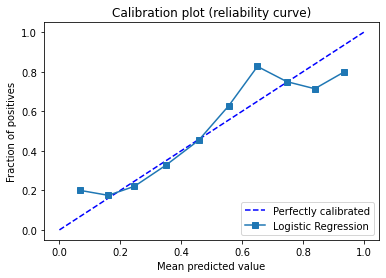

In [24]:
#Calibration plot
import math
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Perfectly calibrated")
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")
ax.set_title('Calibration plot (reliability curve)')

predicted_probs = [1/(1+math.exp(-np.dot(optimized_theta, X_val[i,:]))) for i in range(X_val.shape[0])]
fraction_of_positives, mean_predicted_value = calibration_curve(y_val,predicted_probs, n_bins=10)
ax.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % ('Logistic Regression'))

ax.legend(loc="lower right")
plt.show()

As we shall see from the figure above, on the x-axis, is the mean predicted probability for each bin, and on the y-axis is the fraction of positives. The diagonal dotted line represents the perfectly calibrated model. When the logistic regression model goes below the diagonal, the model is over-forecasting. Above the diagonal, the logistic regression model is under-forecasting.